In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import roc_auc_score


# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset=load_dataset('Falah/Alzheimer_MRI', split='test')

# 데이터셋을 80:20 비율로 나누어 학습 및 검증 데이터셋 생성
train_test_split = dataset.train_test_split(test_size=0.2)  # 80% train, 20% validation

# 새로운 데이터셋 분할 결과
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

# 데이터셋 길이 확인
print(f"Train set: {len(train_dataset)}")
print(f"Validation set: {len(validation_dataset)}")
print(f"Test set: {len(test_dataset)}")

# 레이블 추출 
train_labels = train_dataset['label']   # 훈련 레이블
val_labels = validation_dataset['label']  # 검증 레이블
test_labels = test_dataset['label']      # 테스트 레이블

train_labels = np.array(train_labels)  # train_labels를 numpy 배열로 변환
val_labels = np.array(val_labels)      # val_labels를 numpy 배열로 변환
test_labels = np.array(test_labels)    # test_labels를 numpy 배열로 변환

# 레이블 값의 고유값 확인
print("Train labels unique values:", np.unique(train_labels))
print("Validation labels unique values:", np.unique(val_labels))
print("Test labels unique values:", np.unique(test_labels))

# 레이블 값의 최소 및 최대 값 확인
print("Train labels min and max:", train_labels.min(), train_labels.max())
print("Validation labels min and max:", val_labels.min(), val_labels.max())
print("Test labels min and max:", test_labels.min(), test_labels.max())


# 이미지 전처리 (PIL 이미지를 텐서로 변환)
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 [0, 1] 범위의 텐서로 변환
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1채널 이미지를 3채널로 복제
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화 (회색조 이미지 기준)
])

# MRI_Dataset 클래스 정의
class MRI_Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset  # Hugging Face 데이터셋을 받음
        self.transform = transform  # 이미지 변환을 위한 트랜스폼

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']  # 이미지 데이터 (PIL.Image)
        label = self.dataset[idx]['label']  # 레이블

        # 이미지를 텐서로 변환 및 정규화
        if self.transform:
            image = self.transform(image)

        return image, label

# Train과 Validation 데이터셋에 대한 DataLoader 생성
train_dataset = MRI_Dataset(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = MRI_Dataset(validation_dataset)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = MRI_Dataset(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train set: 4096
Validation set: 1024
Test set: 1280
Train labels unique values: [0 1 2 3]
Validation labels unique values: [0 1 2 3]
Test labels unique values: [0 1 2 3]
Train labels min and max: 0 3
Validation labels min and max: 0 3
Test labels min and max: 0 3


#### 오버샘플링

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from collections import Counter

# 각 클래스별 인덱스 수집
class_indices = {label: [i for i, lbl in enumerate(train_labels) if lbl == label] for label in set(train_labels)}

# 가장 많은 클래스 샘플 수에 맞추어 각 클래스별 오버샘플링
max_class_count = max(len(indices) for indices in class_indices.values())
oversampled_datasets = []

for label, indices in class_indices.items():
    oversample_factor = max_class_count // len(indices)  # 오버샘플링 비율
    oversampled_indices = indices * oversample_factor
    oversampled_indices = oversampled_indices[:max_class_count]  # 정확히 max_class_count에 맞춤
    oversampled_datasets.append(Subset(train_dataset, oversampled_indices))

# 결합된 균형 잡힌 데이터셋 생성
balanced_train_dataset = ConcatDataset(oversampled_datasets)

# DataLoader 생성
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

In [ ]:
# 각 클래스별 인덱스 수집
class_indices = {label: [i for i, lbl in enumerate(train_labels) if lbl == label] for label in set(train_labels)}

# 가장 많은 클래스 샘플 수에 맞추어 각 클래스별 오버샘플링
max_class_count = max(len(indices) for indices in class_indices.values())
oversampled_datasets = []

for label, indices in class_indices.items():
    oversample_factor = max_class_count // len(indices)  # 오버샘플링 비율
    oversampled_indices = indices * oversample_factor
    remaining_samples = max_class_count - len(oversampled_indices)  # 남은 샘플 수를 채우기 위한 추가 샘플
    oversampled_indices += indices[:remaining_samples]  # 남은 샘플을 추가
    oversampled_datasets.append(Subset(train_dataset, oversampled_indices))

# 결합된 균형 잡힌 데이터셋 생성
balanced_train_dataset = ConcatDataset(oversampled_datasets)

# DataLoader 생성
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

In [ ]:
# balanced_train_dataset의 라벨 수 확인
train_labels2 = []
for _, label in balanced_train_dataset:
    train_labels2.append(label)

label_counts = Counter(train_labels2)
print("Balanced dataset label counts:", label_counts)

Balanced dataset label counts: Counter({0: 2039, 1: 2039, 2: 2039, 3: 2039})


In [ ]:
def count_labels(labels):
    label_counts = Counter(labels)
    return label_counts

train_label_counts = count_labels(train_labels)
print("Train Label counts:", train_label_counts)
test_label_counts = count_labels(test_labels)
print("Test Label counts:", test_label_counts)
val_label_counts = count_labels(val_labels)
print("Val Label counts:", val_label_counts)

Train Label counts: Counter({2: 2039, 3: 1439, 0: 579, 1: 39})
Test Label counts: Counter({2: 634, 3: 459, 0: 172, 1: 15})
Val Label counts: Counter({2: 527, 3: 342, 0: 145, 1: 10})


Epoch 1/50
Train Loss: 0.9771, Train Accuracy: 0.5734
Validation Loss: 0.8178, Validation Accuracy: 0.6299, AUC: 0.8693
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.49      0.68      0.57       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.83      0.59      0.69       527
     Class 3       0.51      0.65      0.57       342

    accuracy                           0.63      1024
   macro avg       0.71      0.73      0.71      1024
weighted avg       0.68      0.63      0.64      1024



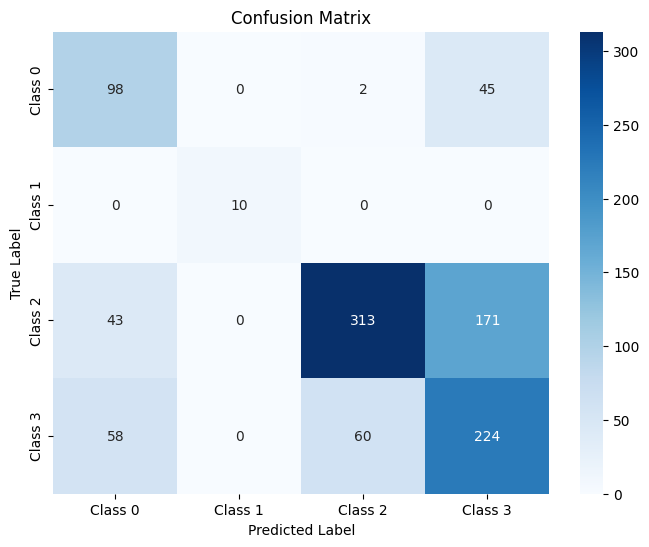

Epoch 2/50
Train Loss: 0.4773, Train Accuracy: 0.7944
Validation Loss: 0.5629, Validation Accuracy: 0.7461, AUC: 0.9282
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.63      0.89      0.74       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.77      0.87      0.82       527
     Class 3       0.78      0.49      0.60       342

    accuracy                           0.75      1024
   macro avg       0.79      0.81      0.79      1024
weighted avg       0.76      0.75      0.74      1024



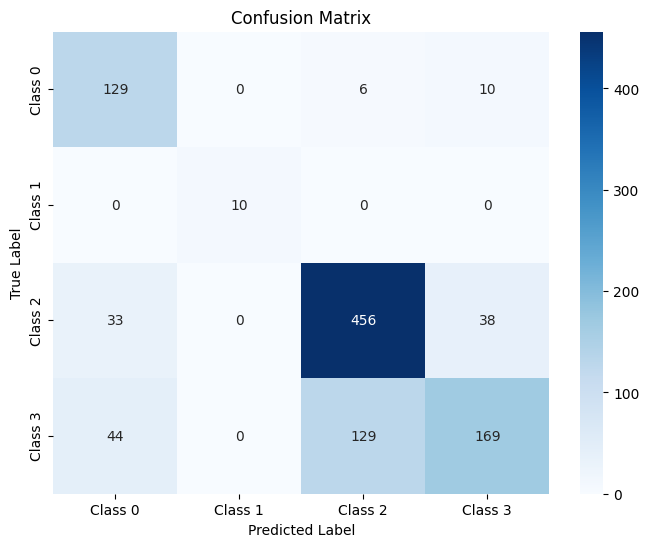

Epoch 3/50
Train Loss: 0.3040, Train Accuracy: 0.8753
Validation Loss: 0.5031, Validation Accuracy: 0.7754, AUC: 0.9457
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.68      0.93      0.78       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.89      0.73      0.80       527
     Class 3       0.69      0.77      0.73       342

    accuracy                           0.78      1024
   macro avg       0.81      0.86      0.83      1024
weighted avg       0.79      0.78      0.78      1024



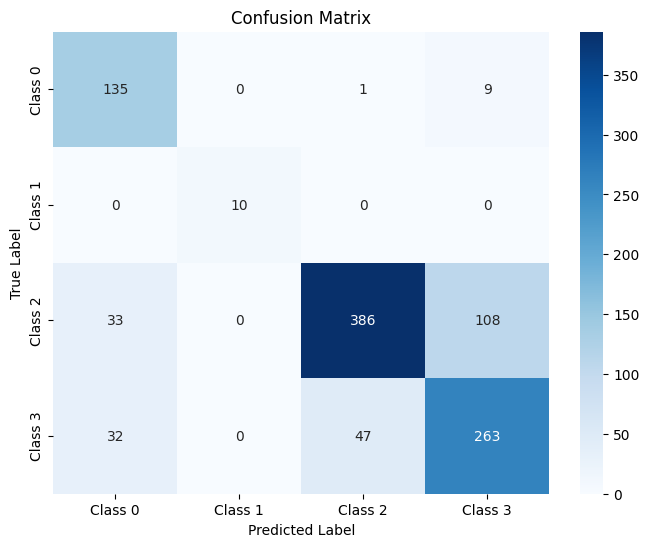

Epoch 4/50
Train Loss: 0.2072, Train Accuracy: 0.9204
Validation Loss: 0.3678, Validation Accuracy: 0.8369, AUC: 0.9732
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.94      0.88       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.94      0.78      0.85       527
     Class 3       0.73      0.88      0.80       342

    accuracy                           0.84      1024
   macro avg       0.87      0.90      0.88      1024
weighted avg       0.85      0.84      0.84      1024



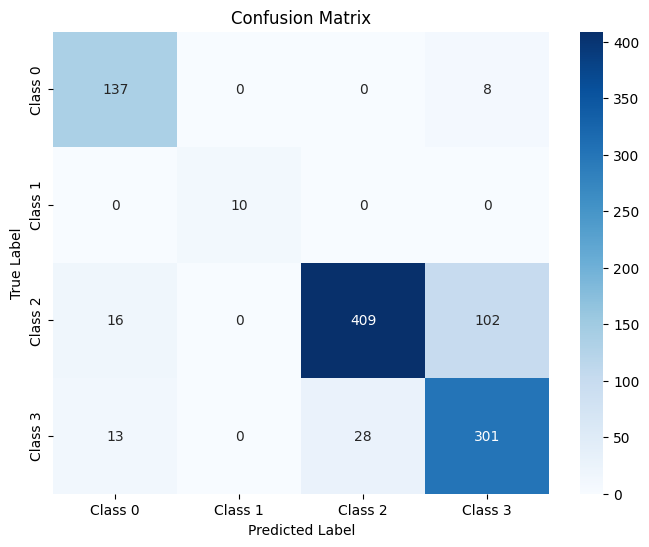

Epoch 5/50
Train Loss: 0.1296, Train Accuracy: 0.9474
Validation Loss: 0.2725, Validation Accuracy: 0.8848, AUC: 0.9852
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.82      0.98      0.89       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.84      0.90       527
     Class 3       0.82      0.91      0.86       342

    accuracy                           0.88      1024
   macro avg       0.90      0.93      0.91      1024
weighted avg       0.89      0.88      0.89      1024



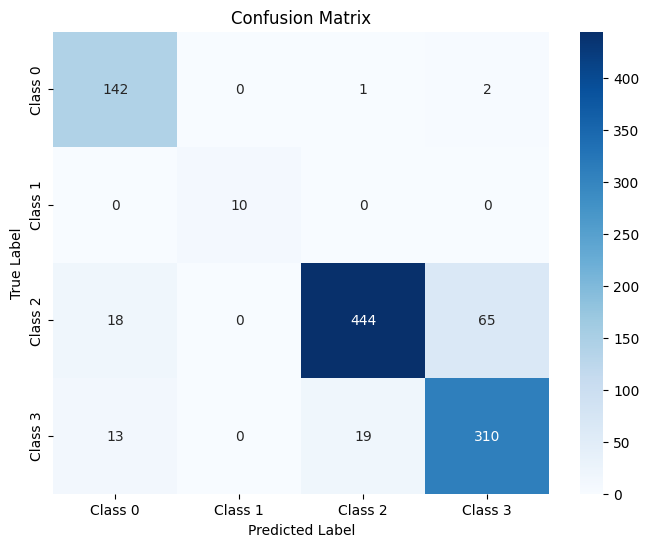

Epoch 6/50
Train Loss: 0.0870, Train Accuracy: 0.9679
Validation Loss: 0.2229, Validation Accuracy: 0.9170, AUC: 0.9886
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.91      0.93       527
     Class 3       0.86      0.92      0.89       342

    accuracy                           0.92      1024
   macro avg       0.94      0.94      0.94      1024
weighted avg       0.92      0.92      0.92      1024



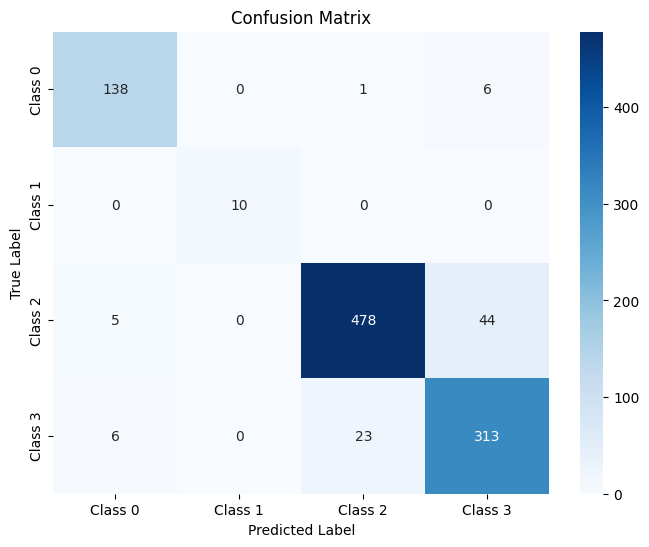

Epoch 7/50
Train Loss: 0.0679, Train Accuracy: 0.9744
Validation Loss: 0.1607, Validation Accuracy: 0.9404, AUC: 0.9933
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.93      0.97      0.95       527
     Class 3       0.95      0.88      0.92       342

    accuracy                           0.94      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.94      0.94      0.94      1024



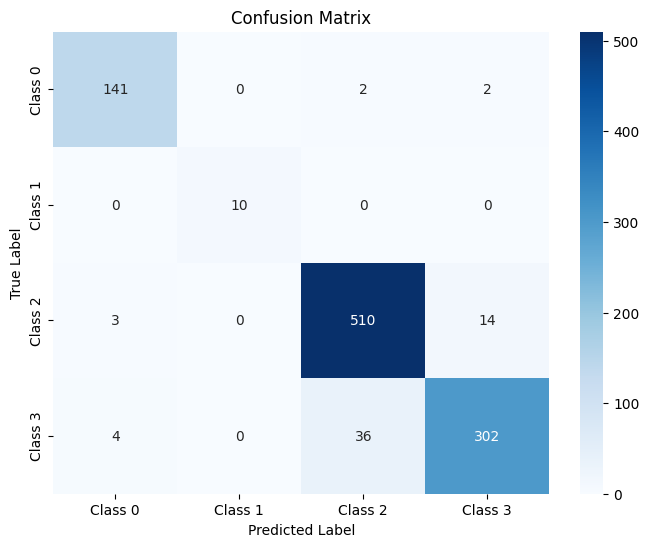

Epoch 8/50
Train Loss: 0.0534, Train Accuracy: 0.9812
Validation Loss: 0.1505, Validation Accuracy: 0.9463, AUC: 0.9953
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.94      0.95       527
     Class 3       0.90      0.96      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



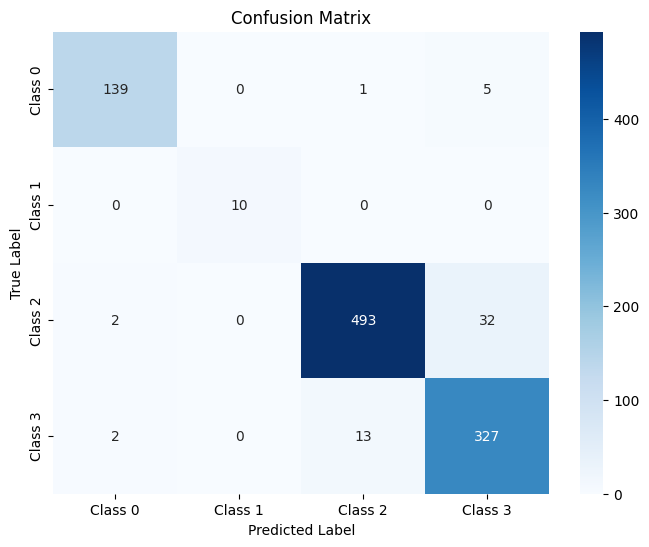

Epoch 9/50
Train Loss: 0.0499, Train Accuracy: 0.9815
Validation Loss: 0.1580, Validation Accuracy: 0.9404, AUC: 0.9947
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.88      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.94      0.97      0.96       527
     Class 3       0.92      0.92      0.92       342

    accuracy                           0.94      1024
   macro avg       0.96      0.94      0.95      1024
weighted avg       0.94      0.94      0.94      1024



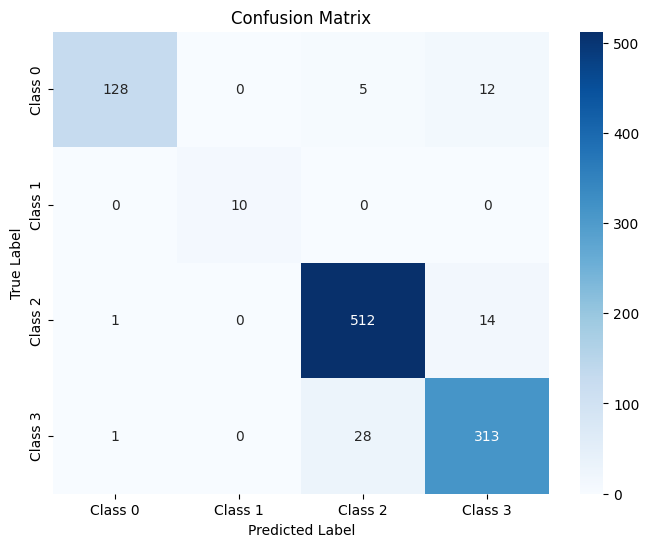

Epoch 10/50
Train Loss: 0.0411, Train Accuracy: 0.9846
Validation Loss: 0.1710, Validation Accuracy: 0.9453, AUC: 0.9931
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.96      0.95       527
     Class 3       0.92      0.93      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.95      0.96      1024
weighted avg       0.95      0.95      0.95      1024



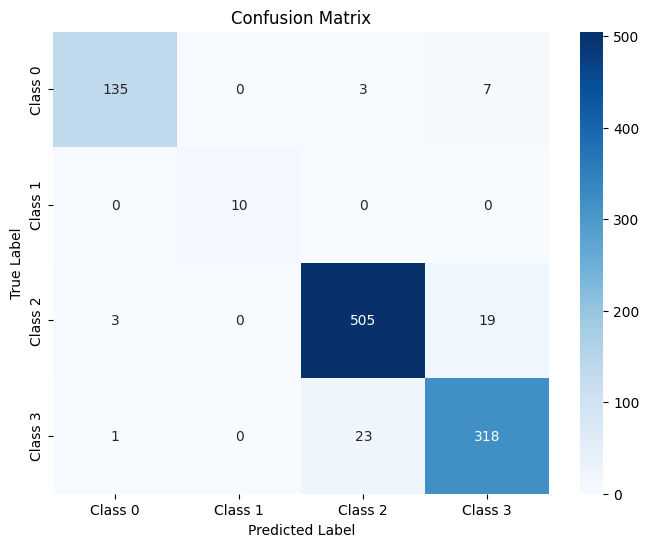

Epoch 11/50
Train Loss: 0.0332, Train Accuracy: 0.9882
Validation Loss: 0.1392, Validation Accuracy: 0.9561, AUC: 0.9950
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.96      0.96       527
     Class 3       0.94      0.94      0.94       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



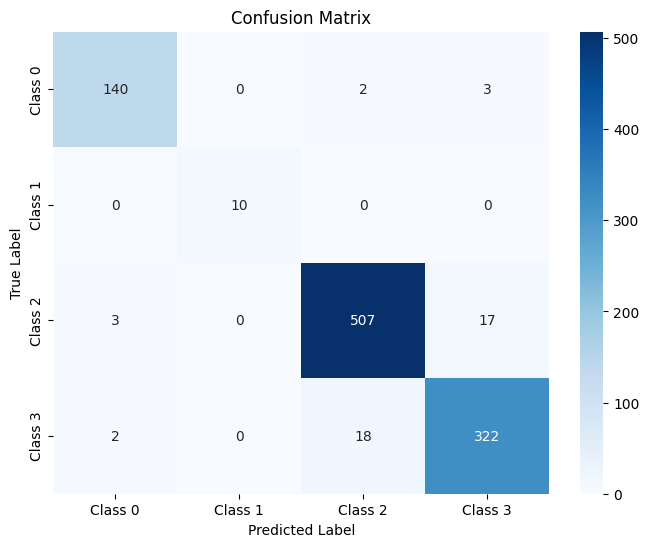

Epoch 12/50
Train Loss: 0.0341, Train Accuracy: 0.9874
Validation Loss: 0.1535, Validation Accuracy: 0.9473, AUC: 0.9947
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.96      0.96       527
     Class 3       0.94      0.92      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



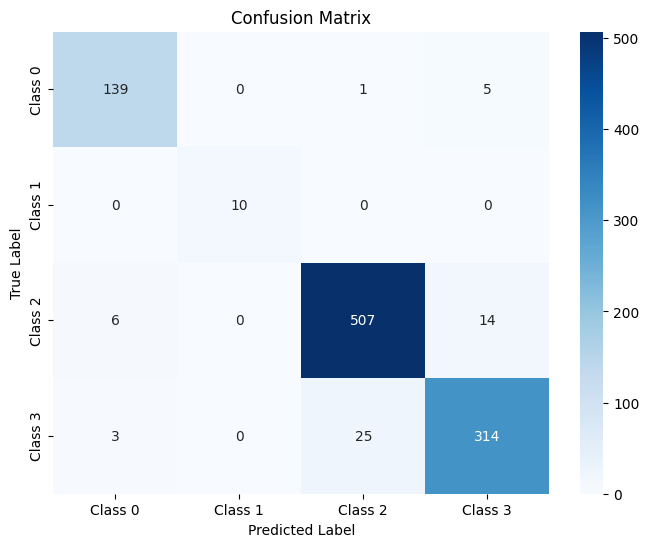

Epoch 13/50
Train Loss: 0.0294, Train Accuracy: 0.9906
Validation Loss: 0.1937, Validation Accuracy: 0.9375, AUC: 0.9952
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.89      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.91      1.00      0.95       527
     Class 3       0.97      0.87      0.91       342

    accuracy                           0.94      1024
   macro avg       0.96      0.94      0.95      1024
weighted avg       0.94      0.94      0.94      1024



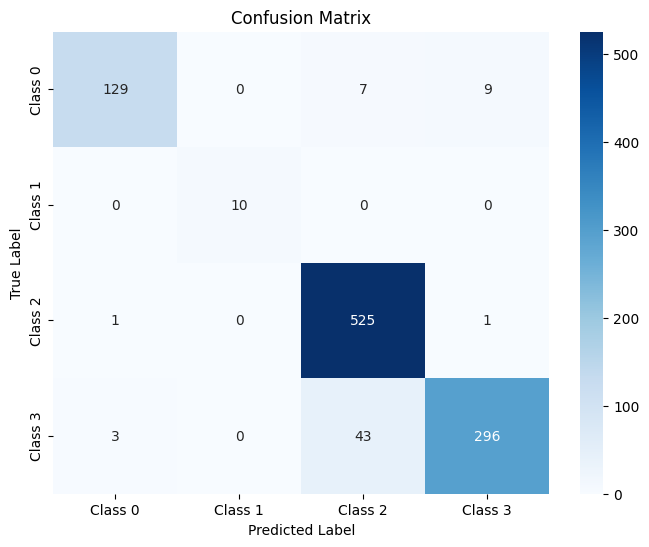

Epoch 14/50
Train Loss: 0.0228, Train Accuracy: 0.9917
Validation Loss: 0.1795, Validation Accuracy: 0.9404, AUC: 0.9955
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.99      0.91      0.95       527
     Class 3       0.89      0.97      0.93       342

    accuracy                           0.94      1024
   macro avg       0.95      0.96      0.95      1024
weighted avg       0.94      0.94      0.94      1024



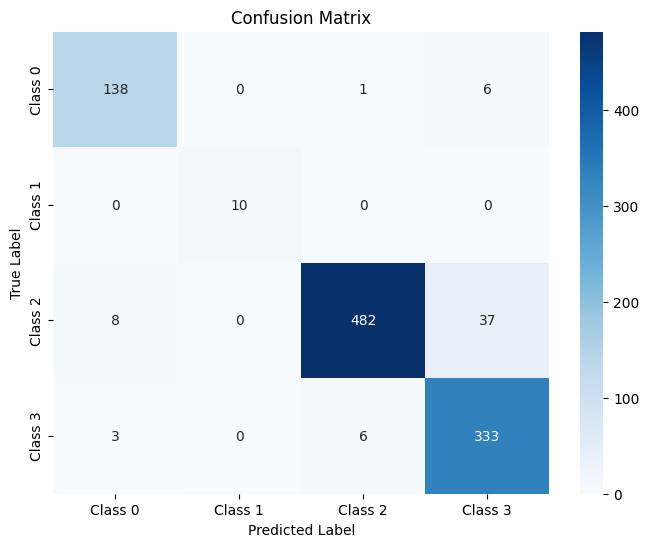

Epoch 15/50
Train Loss: 0.0237, Train Accuracy: 0.9910
Validation Loss: 0.1297, Validation Accuracy: 0.9600, AUC: 0.9961
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.92      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.97       527
     Class 3       0.95      0.95      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.96      0.97      1024
weighted avg       0.96      0.96      0.96      1024



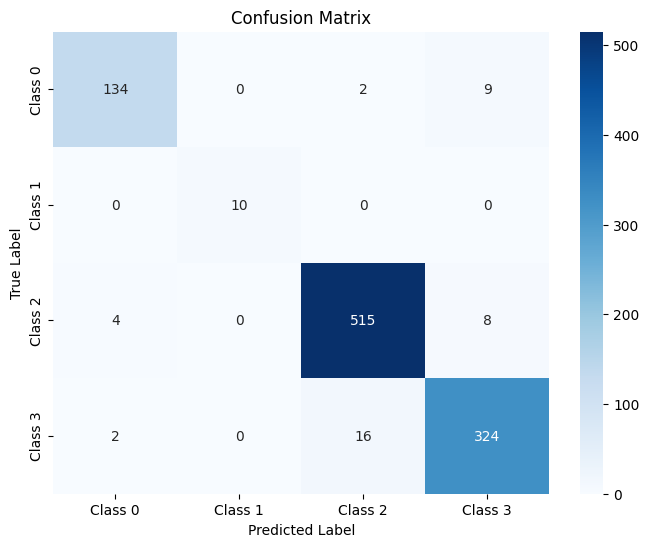

Epoch 16/50
Train Loss: 0.0238, Train Accuracy: 0.9925
Validation Loss: 0.1328, Validation Accuracy: 0.9521, AUC: 0.9962
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.96      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.96      0.96       527
     Class 3       0.93      0.94      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



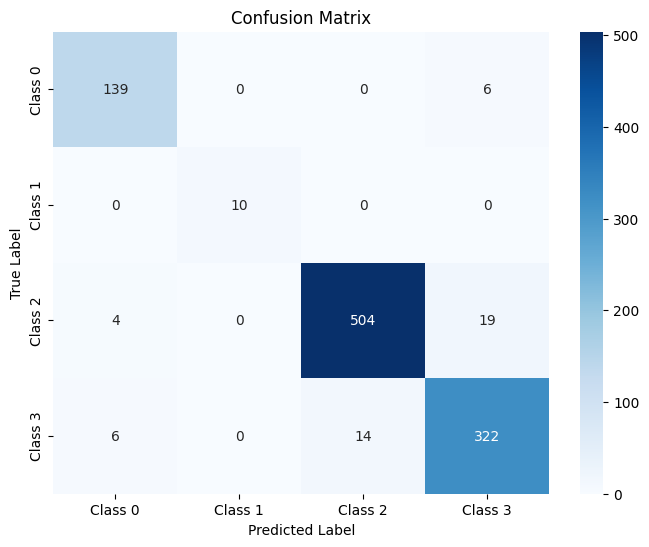

Epoch 17/50
Train Loss: 0.0420, Train Accuracy: 0.9860
Validation Loss: 0.1459, Validation Accuracy: 0.9590, AUC: 0.9959
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.99      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.97      0.97       527
     Class 3       0.97      0.92      0.95       342

    accuracy                           0.96      1024
   macro avg       0.96      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



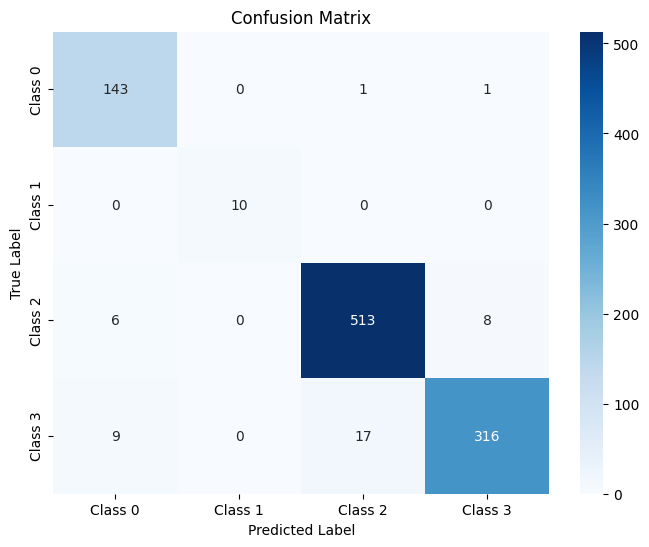

Epoch 18/50
Train Loss: 0.0190, Train Accuracy: 0.9929
Validation Loss: 0.1635, Validation Accuracy: 0.9570, AUC: 0.9962
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.99      0.97       527
     Class 3       0.98      0.90      0.94       342

    accuracy                           0.96      1024
   macro avg       0.97      0.96      0.96      1024
weighted avg       0.96      0.96      0.96      1024



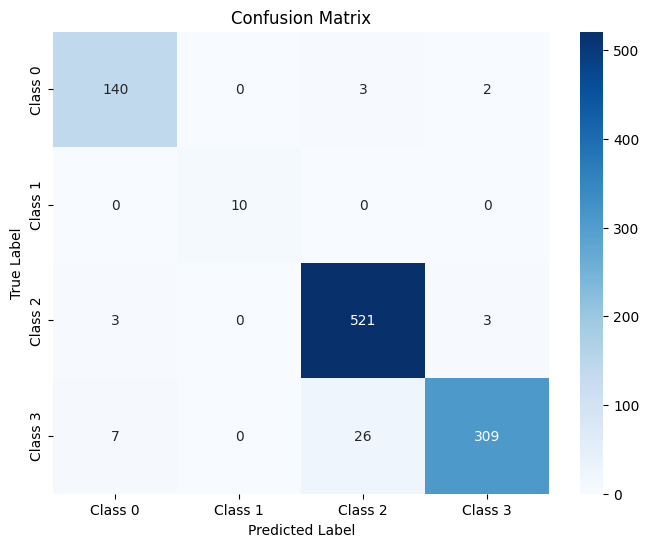

Epoch 19/50
Train Loss: 0.0179, Train Accuracy: 0.9935
Validation Loss: 0.1847, Validation Accuracy: 0.9482, AUC: 0.9954
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.94      0.96       527
     Class 3       0.93      0.95      0.94       342

    accuracy                           0.95      1024
   macro avg       0.95      0.97      0.96      1024
weighted avg       0.95      0.95      0.95      1024



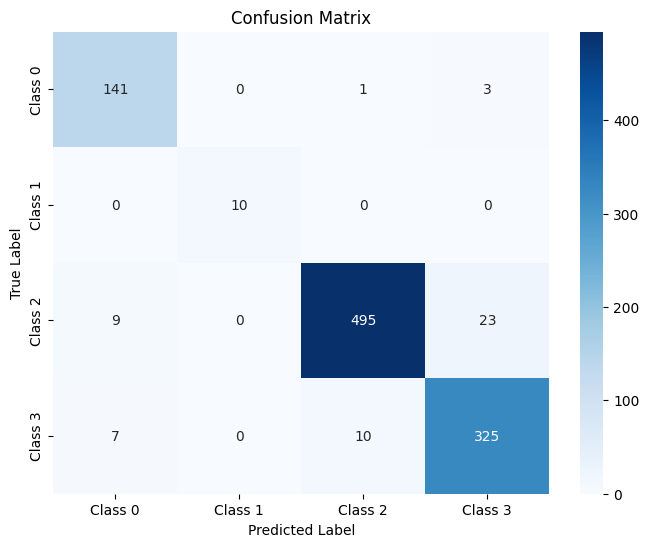

Epoch 20/50
Train Loss: 0.0207, Train Accuracy: 0.9931
Validation Loss: 0.1876, Validation Accuracy: 0.9502, AUC: 0.9953
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.97      0.96       527
     Class 3       0.97      0.91      0.94       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



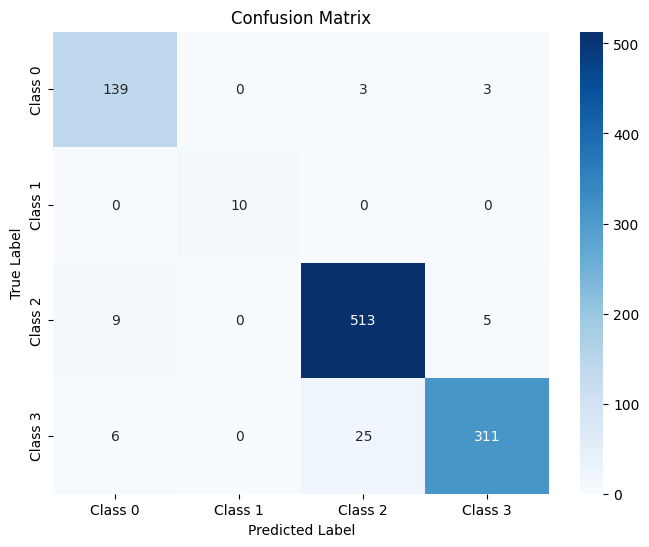

Epoch 21/50
Train Loss: 0.0261, Train Accuracy: 0.9906
Validation Loss: 0.1527, Validation Accuracy: 0.9502, AUC: 0.9958
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.97      0.96       527
     Class 3       0.96      0.92      0.94       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



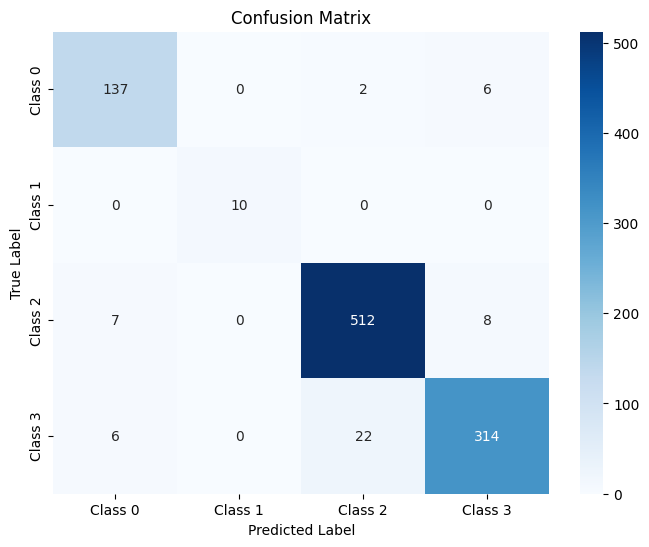

Epoch 22/50
Train Loss: 0.0179, Train Accuracy: 0.9945
Validation Loss: 0.1525, Validation Accuracy: 0.9561, AUC: 0.9962
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.96      0.97       527
     Class 3       0.94      0.95      0.94       342

    accuracy                           0.96      1024
   macro avg       0.96      0.97      0.96      1024
weighted avg       0.96      0.96      0.96      1024



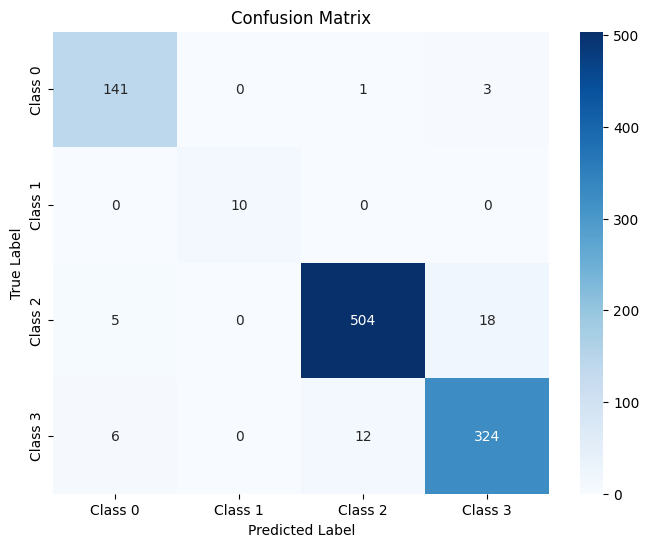

Epoch 23/50
Train Loss: 0.0176, Train Accuracy: 0.9936
Validation Loss: 0.1489, Validation Accuracy: 0.9629, AUC: 0.9967
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.92      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.98       527
     Class 3       0.95      0.95      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.96      0.97      1024
weighted avg       0.96      0.96      0.96      1024



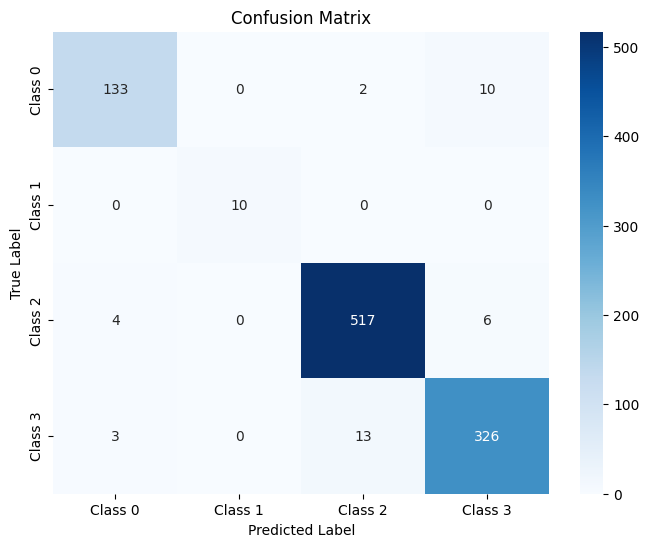

Epoch 24/50
Train Loss: 0.0209, Train Accuracy: 0.9926
Validation Loss: 0.1535, Validation Accuracy: 0.9668, AUC: 0.9968
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.98       527
     Class 3       0.98      0.93      0.96       342

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



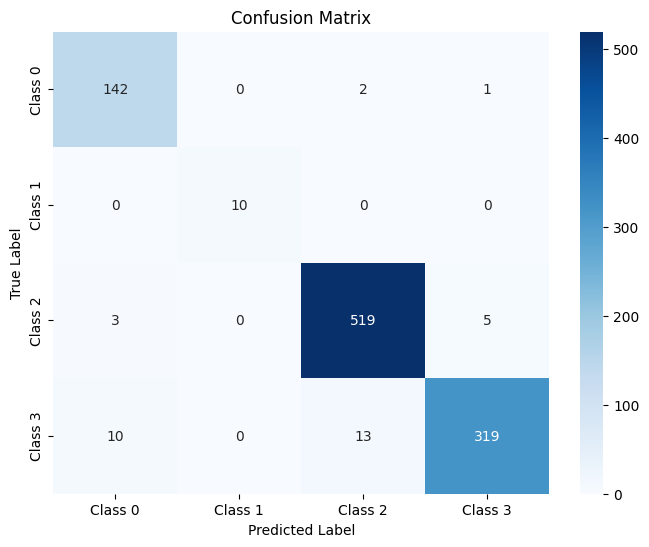

Epoch 25/50
Train Loss: 0.0214, Train Accuracy: 0.9928
Validation Loss: 0.1870, Validation Accuracy: 0.9521, AUC: 0.9953
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.95      0.96       527
     Class 3       0.92      0.95      0.94       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



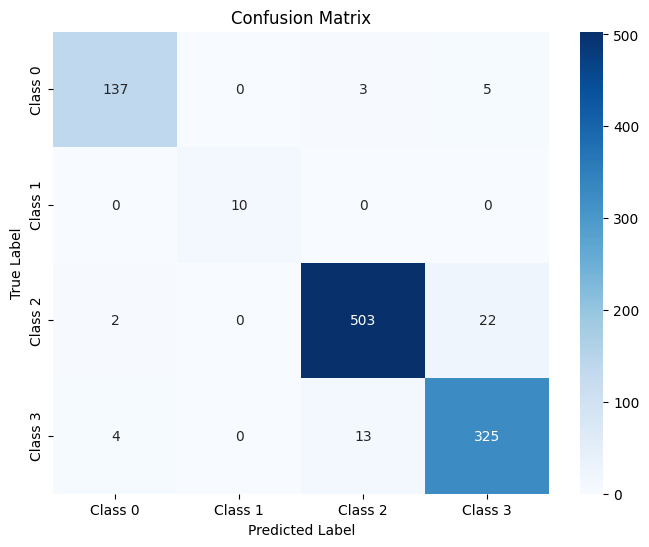

Epoch 26/50
Train Loss: 0.0186, Train Accuracy: 0.9925
Validation Loss: 0.1742, Validation Accuracy: 0.9580, AUC: 0.9964
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.94      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.98      0.97       527
     Class 3       0.97      0.92      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.96      0.97      1024
weighted avg       0.96      0.96      0.96      1024



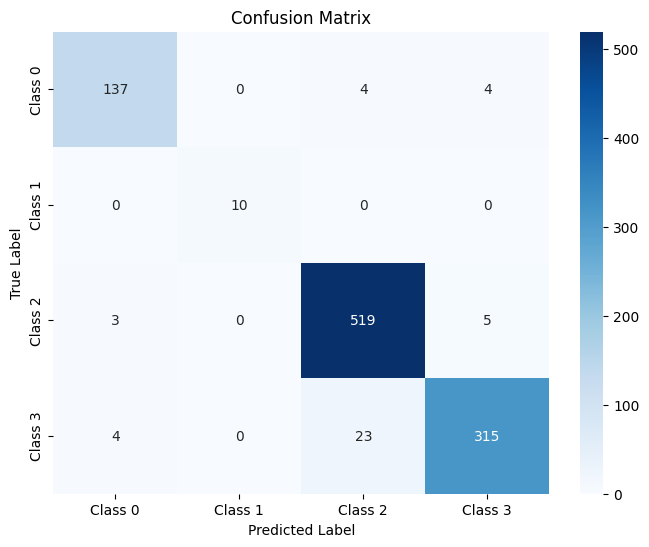

Epoch 27/50
Train Loss: 0.0255, Train Accuracy: 0.9915
Validation Loss: 0.1936, Validation Accuracy: 0.9443, AUC: 0.9956
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.93      0.99      0.96       527
     Class 3       0.98      0.87      0.92       342

    accuracy                           0.94      1024
   macro avg       0.96      0.95      0.95      1024
weighted avg       0.95      0.94      0.94      1024



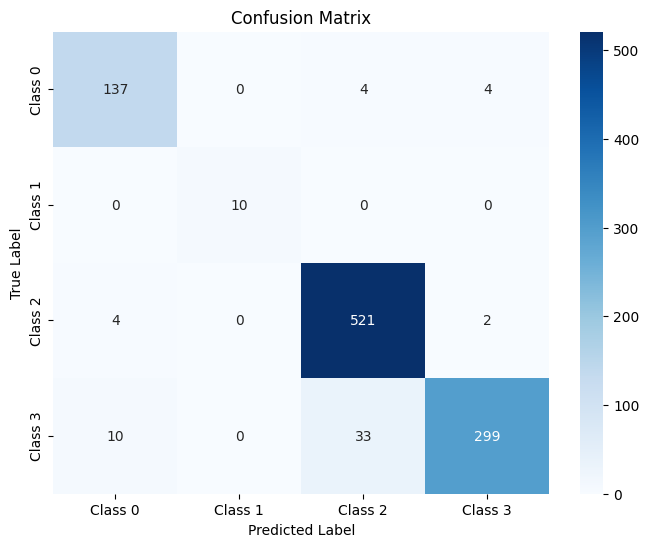

Epoch 28/50
Train Loss: 0.0188, Train Accuracy: 0.9931
Validation Loss: 0.1803, Validation Accuracy: 0.9512, AUC: 0.9963
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.94      0.99      0.96       527
     Class 3       0.97      0.89      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



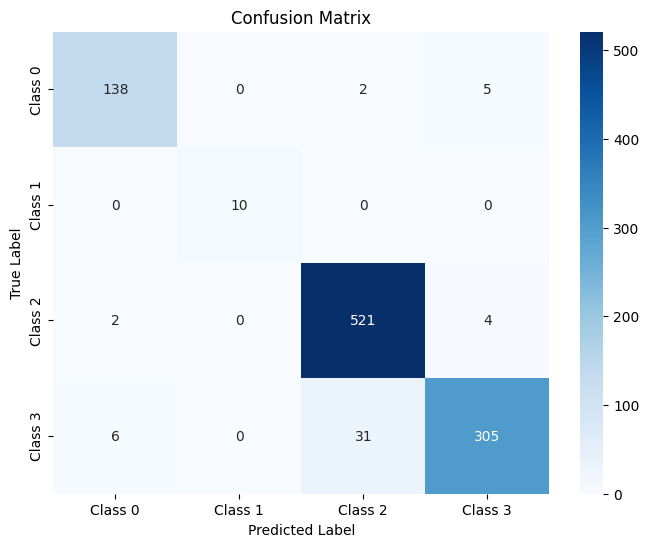

Epoch 29/50
Train Loss: 0.0174, Train Accuracy: 0.9934
Validation Loss: 0.1569, Validation Accuracy: 0.9600, AUC: 0.9972
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.95      0.96       527
     Class 3       0.92      0.97      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



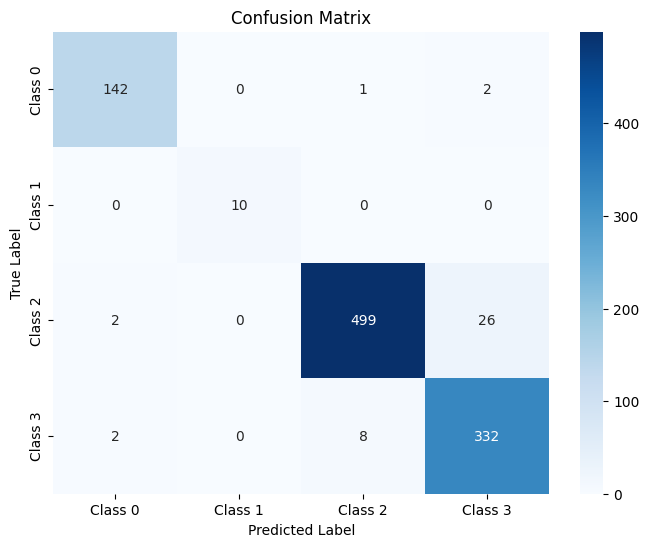

Epoch 30/50
Train Loss: 0.0149, Train Accuracy: 0.9945
Validation Loss: 0.1674, Validation Accuracy: 0.9619, AUC: 0.9967
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.98      0.97       527
     Class 3       0.96      0.94      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



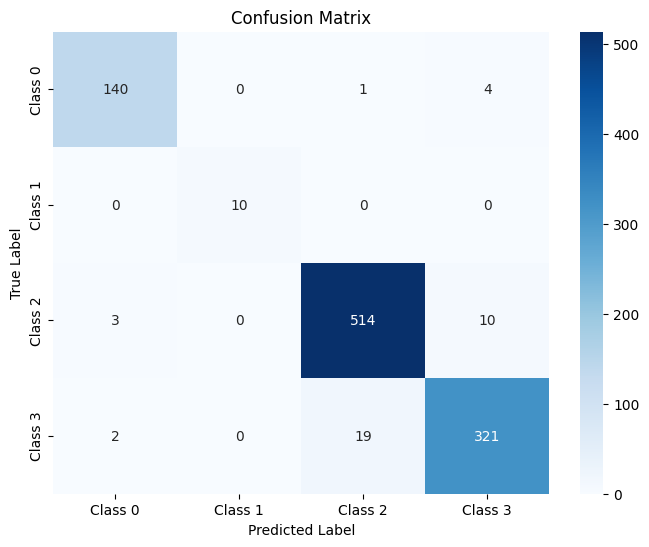

Epoch 31/50
Train Loss: 0.0202, Train Accuracy: 0.9920
Validation Loss: 0.1886, Validation Accuracy: 0.9531, AUC: 0.9968
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.95      0.99      0.97       527
     Class 3       0.98      0.89      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



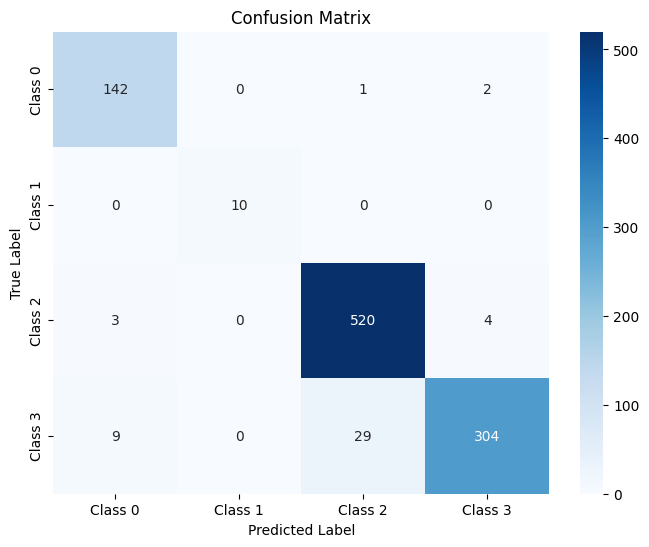

Epoch 32/50
Train Loss: 0.0166, Train Accuracy: 0.9940
Validation Loss: 0.2267, Validation Accuracy: 0.9561, AUC: 0.9957
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.94      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.94      0.99      0.96       527
     Class 3       0.98      0.90      0.94       342

    accuracy                           0.96      1024
   macro avg       0.97      0.96      0.97      1024
weighted avg       0.96      0.96      0.96      1024



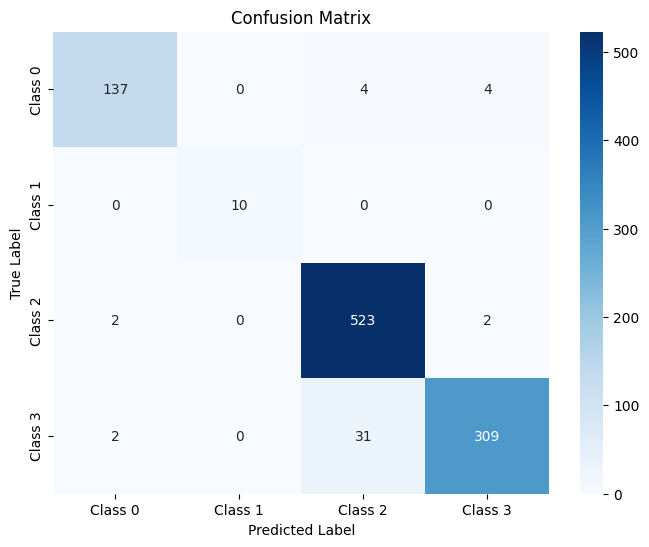

Epoch 33/50
Train Loss: 0.0172, Train Accuracy: 0.9936
Validation Loss: 0.1353, Validation Accuracy: 0.9648, AUC: 0.9970
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.97      0.97       527
     Class 3       0.95      0.96      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.96      0.96      1024



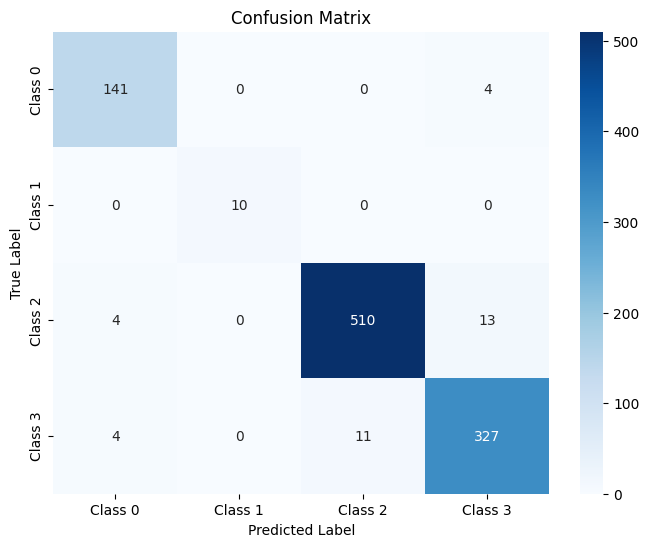

Epoch 34/50
Train Loss: 0.0093, Train Accuracy: 0.9969
Validation Loss: 0.1240, Validation Accuracy: 0.9678, AUC: 0.9974
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.98      0.97       527
     Class 3       0.97      0.94      0.96       342

    accuracy                           0.97      1024
   macro avg       0.98      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



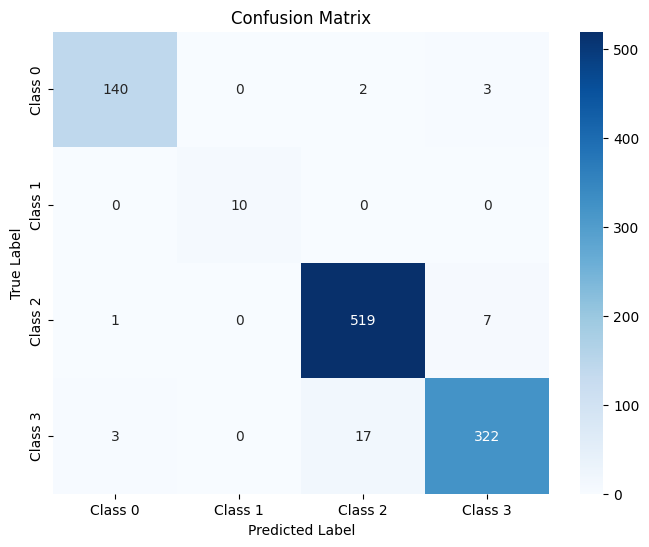

Epoch 35/50
Train Loss: 0.0140, Train Accuracy: 0.9955
Validation Loss: 0.1708, Validation Accuracy: 0.9600, AUC: 0.9969
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.99      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.98      0.98       527
     Class 3       0.97      0.92      0.95       342

    accuracy                           0.96      1024
   macro avg       0.96      0.97      0.96      1024
weighted avg       0.96      0.96      0.96      1024



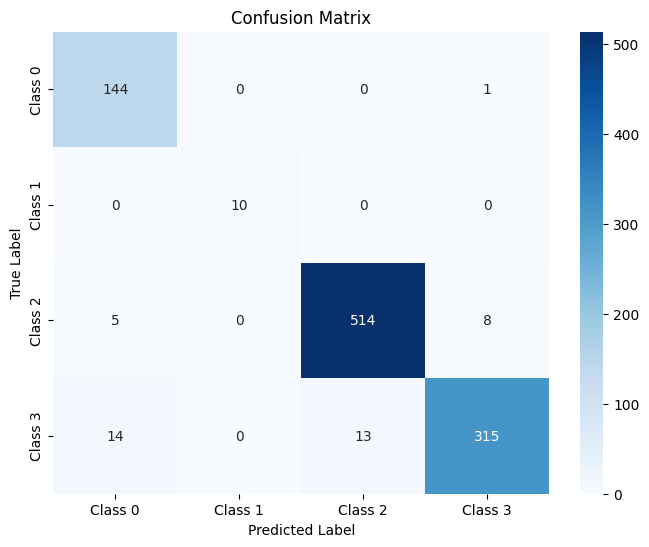

Epoch 36/50
Train Loss: 0.0195, Train Accuracy: 0.9937
Validation Loss: 0.1426, Validation Accuracy: 0.9619, AUC: 0.9971
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.97       527
     Class 3       0.96      0.94      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



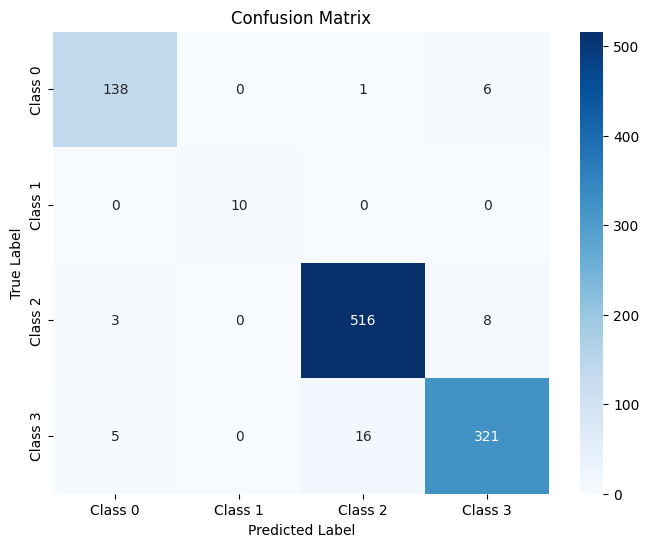

Epoch 37/50
Train Loss: 0.0141, Train Accuracy: 0.9960
Validation Loss: 0.1603, Validation Accuracy: 0.9658, AUC: 0.9963
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.99      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.97      0.98       527
     Class 3       0.96      0.95      0.95       342

    accuracy                           0.97      1024
   macro avg       0.97      0.98      0.97      1024
weighted avg       0.97      0.97      0.97      1024



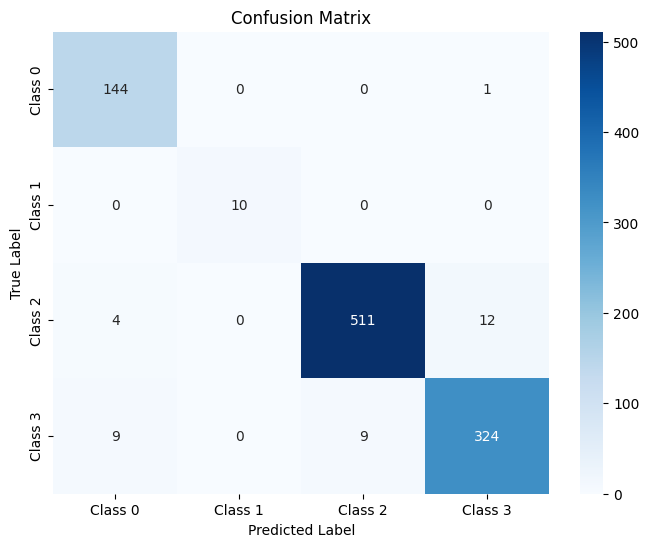

Epoch 38/50
Train Loss: 0.0104, Train Accuracy: 0.9961
Validation Loss: 0.1696, Validation Accuracy: 0.9658, AUC: 0.9970
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.99      0.98       527
     Class 3       0.99      0.93      0.96       342

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



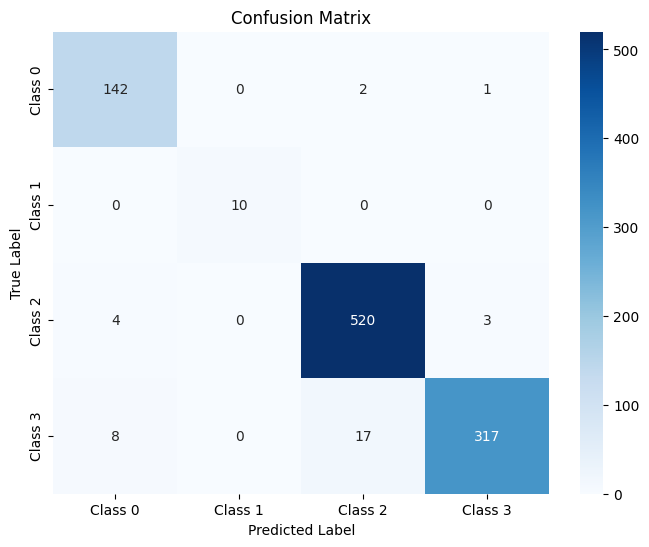

Epoch 39/50
Train Loss: 0.0109, Train Accuracy: 0.9962
Validation Loss: 0.1459, Validation Accuracy: 0.9619, AUC: 0.9971
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.96      0.97       527
     Class 3       0.93      0.96      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



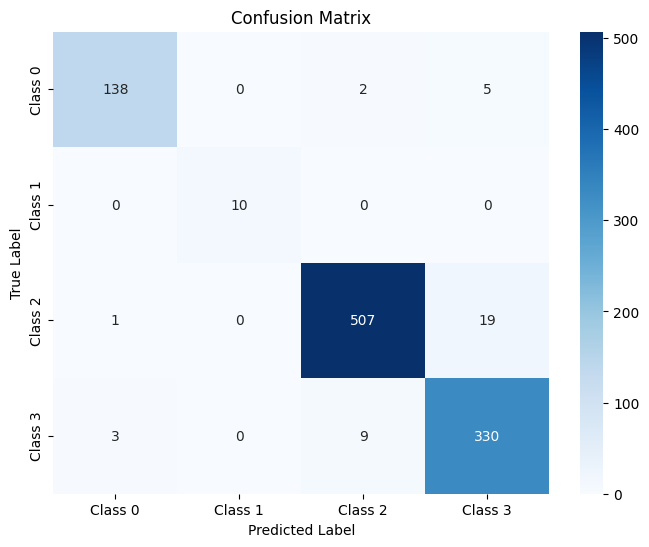

Epoch 40/50
Train Loss: 0.0158, Train Accuracy: 0.9950
Validation Loss: 0.2088, Validation Accuracy: 0.9629, AUC: 0.9958
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.96      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.99      0.97       527
     Class 3       0.98      0.93      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



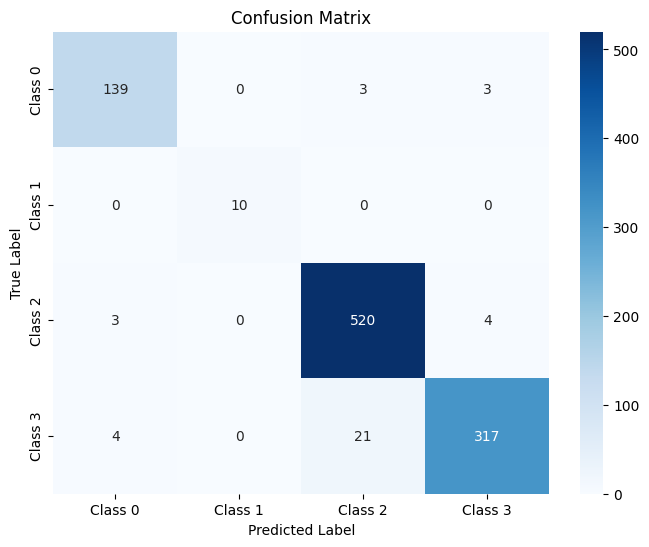

Epoch 41/50
Train Loss: 0.0268, Train Accuracy: 0.9907
Validation Loss: 0.1367, Validation Accuracy: 0.9668, AUC: 0.9969
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.97      0.98       527
     Class 3       0.94      0.97      0.96       342

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



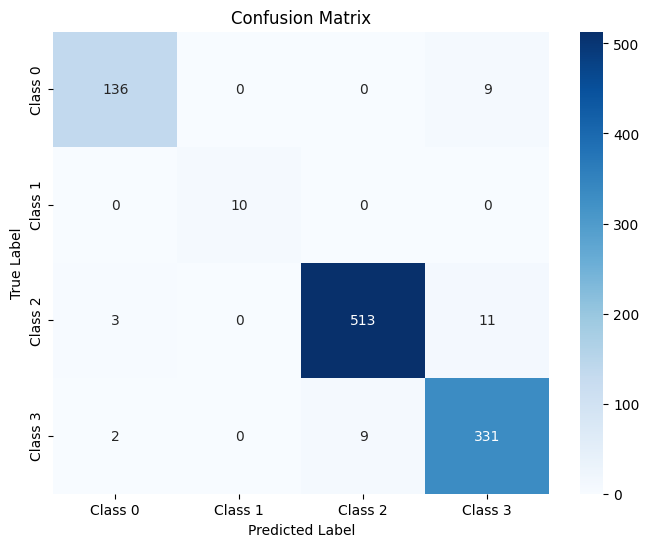

Epoch 42/50
Train Loss: 0.0135, Train Accuracy: 0.9953
Validation Loss: 0.1647, Validation Accuracy: 0.9619, AUC: 0.9964
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.97      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.97       527
     Class 3       0.96      0.93      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



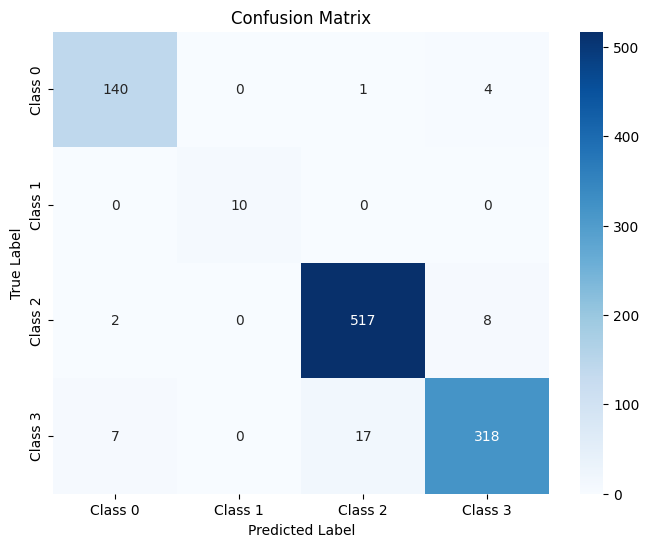

Epoch 43/50
Train Loss: 0.0136, Train Accuracy: 0.9962
Validation Loss: 0.2364, Validation Accuracy: 0.9580, AUC: 0.9948
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.97      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.98      0.97       527
     Class 3       0.96      0.92      0.94       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



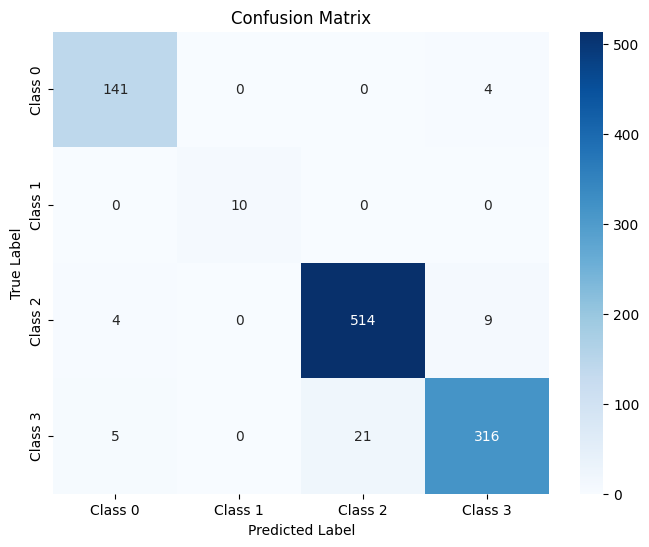

Epoch 44/50
Train Loss: 0.0132, Train Accuracy: 0.9947
Validation Loss: 0.1805, Validation Accuracy: 0.9619, AUC: 0.9960
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.97      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.97      0.97       527
     Class 3       0.95      0.95      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



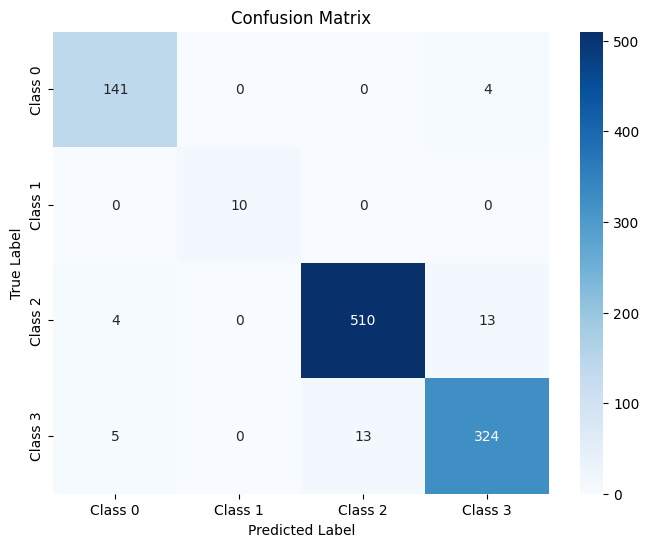

Epoch 45/50
Train Loss: 0.0144, Train Accuracy: 0.9945
Validation Loss: 0.2090, Validation Accuracy: 0.9492, AUC: 0.9942
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.97      0.94       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.96      0.96       527
     Class 3       0.95      0.92      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



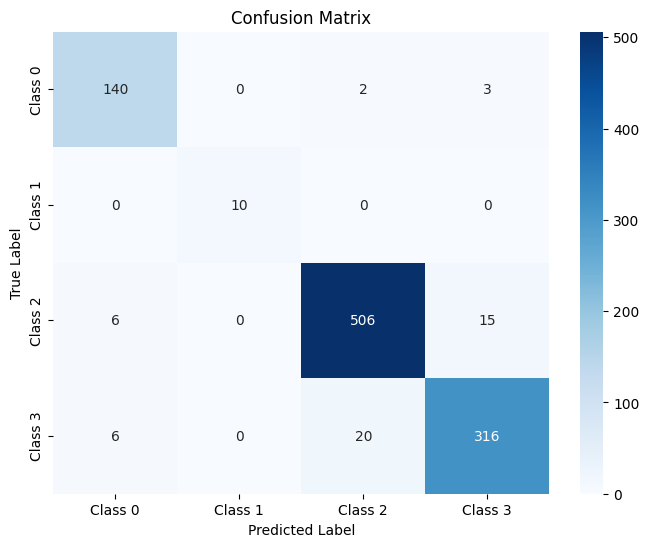

Epoch 46/50
Train Loss: 0.0203, Train Accuracy: 0.9930
Validation Loss: 0.1846, Validation Accuracy: 0.9502, AUC: 0.9960
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.92      0.93       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.96      0.97      0.96       527
     Class 3       0.93      0.94      0.93       342

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



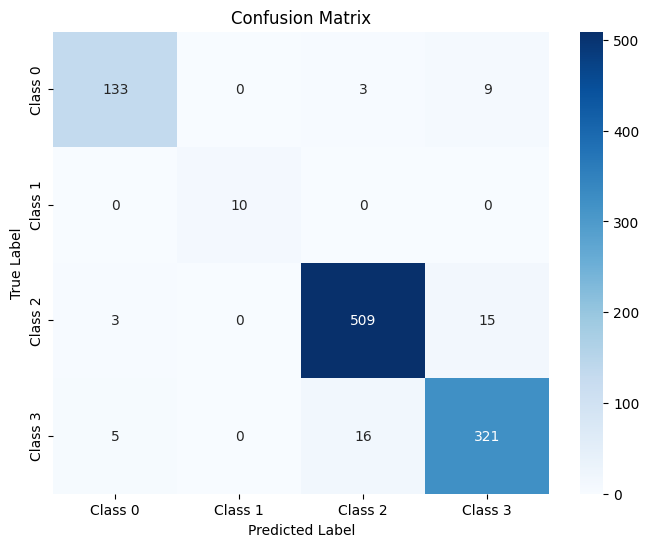

Epoch 47/50
Train Loss: 0.0123, Train Accuracy: 0.9947
Validation Loss: 0.1480, Validation Accuracy: 0.9717, AUC: 0.9967
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.98      0.98       527
     Class 3       0.97      0.95      0.96       342

    accuracy                           0.97      1024
   macro avg       0.98      0.98      0.98      1024
weighted avg       0.97      0.97      0.97      1024



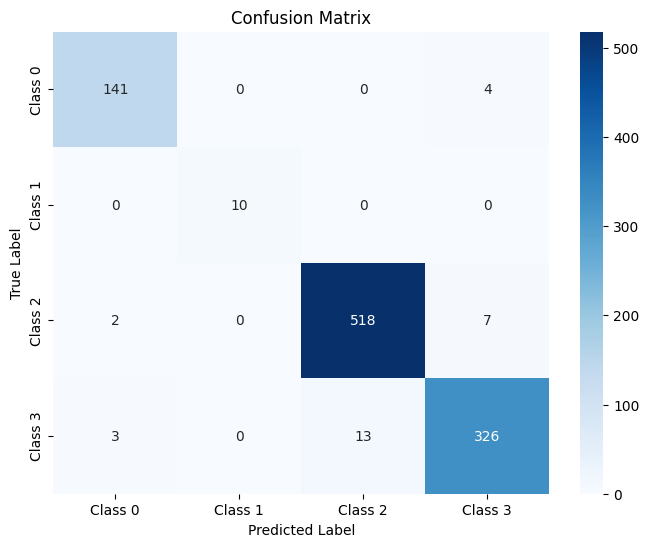

Epoch 48/50
Train Loss: 0.0085, Train Accuracy: 0.9972
Validation Loss: 0.1819, Validation Accuracy: 0.9648, AUC: 0.9967
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.97      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.98      0.97       527
     Class 3       0.97      0.94      0.96       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



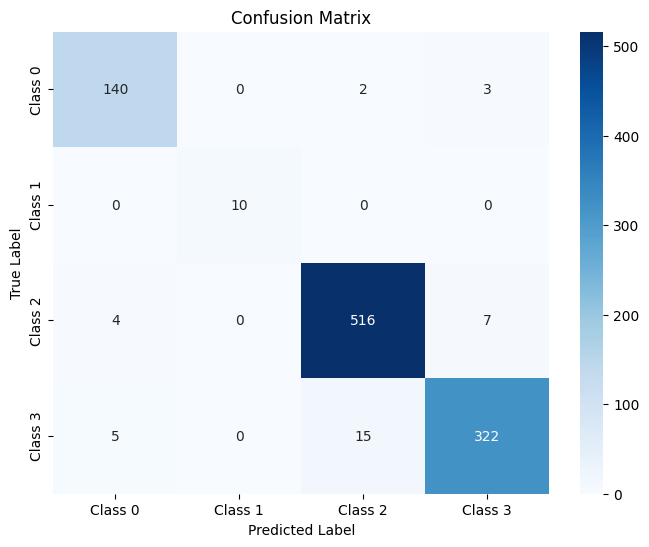

Epoch 49/50
Train Loss: 0.0130, Train Accuracy: 0.9958
Validation Loss: 0.1916, Validation Accuracy: 0.9609, AUC: 0.9962
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.96      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.97      0.97       527
     Class 3       0.94      0.95      0.95       342

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



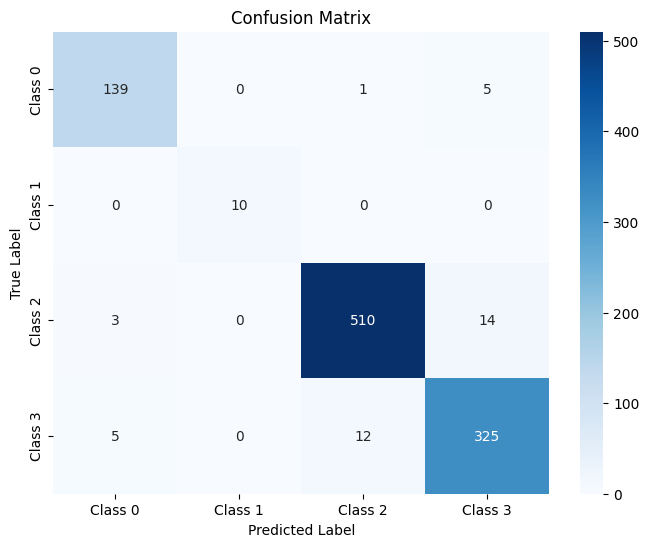

Epoch 50/50
Train Loss: 0.0147, Train Accuracy: 0.9946
Validation Loss: 0.1466, Validation Accuracy: 0.9707, AUC: 0.9974
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.95      0.96       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.98      0.98      0.98       527
     Class 3       0.96      0.96      0.96       342

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



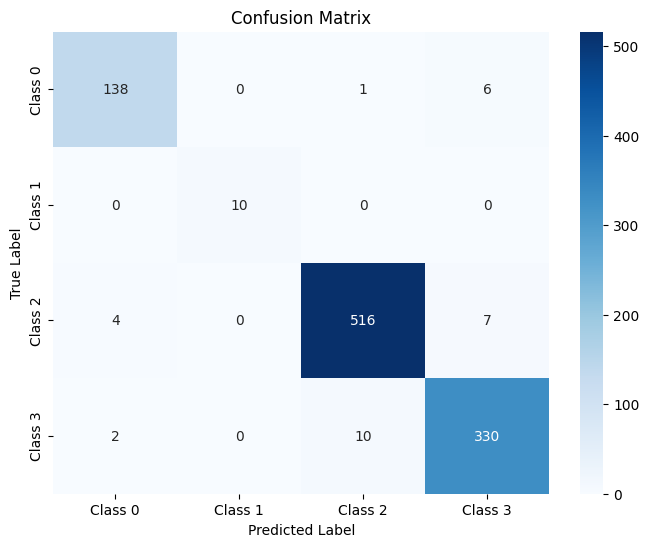


Test Loss: 0.2821, Test Accuracy: 0.9625, Test AUC: 0.9959


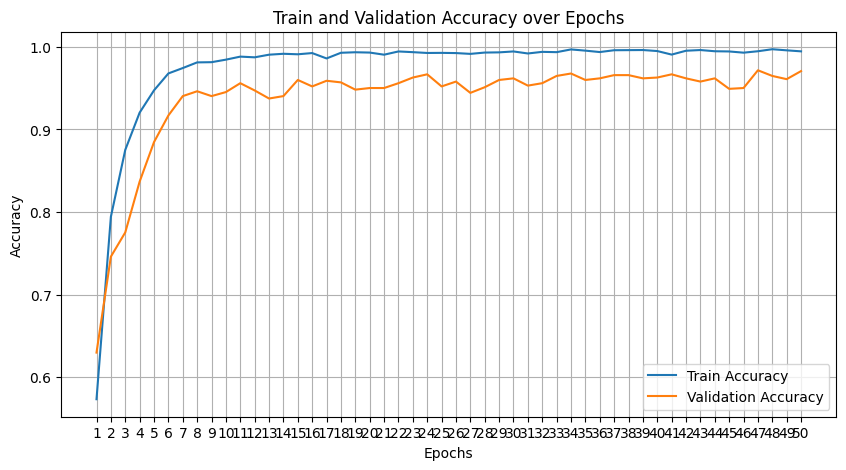

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):  
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 하이퍼파라미터 설정
num_epochs = 50
batch_size = 32
learning_rate = 0.001
num_classes=4

# 손실 함수 (다중 분류를 위한 CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()  # 다중 분류를 위한 손실 함수

def train_epoch(model, data_loader, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)  # CUDA 장치로 이동
        labels = labels.long()  # labels를 정수형으로 변환 (다중 분류를 위해)

        optimizer.zero_grad()  # 경량화 최적화
        outputs = model(images)  # 모델의 출력을 계산
        loss = criterion(outputs, labels)  # 손실 계산

        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()  # 손실 기록
        preds = torch.argmax(outputs, dim=1)  # 예측값을 클래스 인덱스로 변환
        correct += (preds == labels).sum().item()  # 정확도 계산
        total += labels.size(0)  # 전체 데이터 수 기록

    avg_loss = total_loss / len(data_loader)  # 평균 손실 계산
    accuracy = correct / total  # 정확도 계산
    return avg_loss, accuracy

def validate_epoch(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # CUDA 장치로 이동
            labels = labels.long()  # labels를 정수형으로 변환 (다중 분류를 위해)

            outputs = model(images)  # 모델의 출력을 계산
            loss = criterion(outputs, labels)  # 손실 계산

            total_loss += loss.item()  # 손실 기록
            preds = torch.argmax(outputs, dim=1)  # 예측값을 클래스 인덱스로 변환
            correct += (preds == labels).sum().item()  # 정확도 계산
            total += labels.size(0)  # 전체 데이터 수 기록

    avg_loss = total_loss / len(data_loader)  # 평균 손실 계산
    accuracy = correct / total  # 정확도 계산
    return avg_loss, accuracy

def calculate_auc(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    all_labels = []
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # CUDA 장치로 이동
            
            labels = labels.view(-1).cpu().numpy()  # labels를 평탄화하고 CPU로 이동
            outputs = model(images)  # 모델의 출력을 계산
            
            preds = torch.softmax(outputs, dim=1).cpu().numpy()  # 예측 확률로 변환

            all_labels.extend(labels)  # labels를 리스트에 추가
            all_preds.extend(preds)  # preds를 리스트에 추가 (모두 포함)

    # AUC 계산 (다중 클래스일 경우)
    if num_classes == 2:  # 이진 분류
        auc = roc_auc_score(all_labels, [p[1] for p in all_preds])  # 양성 클래스 확률
    else:  # 다중 분류
        auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')  # One-vs-Rest 방식으로 AUC 계산

    return auc

def evaluate_model(model, data_loader, device, num_classes):
    model.eval()  # 모델을 평가 모드로 설정
    all_labels = []
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # CUDA 장치로 이동
            
            labels = labels.view(-1).cpu().numpy()  # labels를 평탄화하고 CPU로 이동
            outputs = model(images)  # 모델의 출력을 계산
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 예측값을 클래스 인덱스로 변환

            all_labels.extend(labels)  # labels를 리스트에 추가
            all_preds.extend(preds)  # preds를 리스트에 추가

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)])
    print("Classification Report:\n", report)

    # Confusion Matrix
    #cm = confusion_matrix(all_labels, all_preds)
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title('Confusion Matrix')
    #plt.show()

# 모델 정의
model = SimpleCNN(num_classes=4)

# 옵티마이저 정의 (기존 코드 유지)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 장치 설정 (GPU 또는 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Accuracy 기록을 위한 리스트 초기화
train_accuracies = []
val_accuracies = []
test_accuracies = []

# 훈련 루프
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, device)  # val_loader를 사용
    val_auc = calculate_auc(model, val_loader, device)

    # Accuracy 기록
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}')
    
     # 모델 성능 평가
    evaluate_model(model, val_loader, device, num_classes)  # 추가된 부분
    
# 테스트셋에서 최종 성능 평가
test_loss, test_acc = validate_epoch(model, test_loader, device)
test_auc = calculate_auc(model, test_loader, device)
print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}')
test_accuracies.append(test_acc)  # 테스트 정확도를 리스트에 추가

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))  # X축을 epoch 숫자로 설정
plt.legend()
plt.grid()
plt.show()

c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

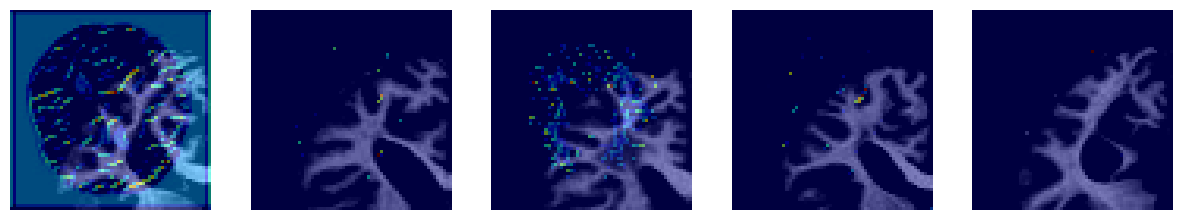

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []

        # 모델을 평가 모드로 설정
        self.model.eval()

        # 활성화와 그래디언트 정보를 저장하기 위해 hook 등록
        self._register_hooks()

    def _register_hooks(self):
        # Forward hook (activation 저장)
        def forward_hook(module, input, output):
            self.activations = output

        # Backward hook (gradients 저장)
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # target_layer에 hooks 등록 (backward_hook만 사용)
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_image, target_class=None):
        # 모델이 위치한 장치로 이미지 이동 (CUDA 지원 시 GPU로 이동)
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)

        # 모델 예측
        output = self.model(input_image)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()  # 예측 클래스 선택

        self.model.zero_grad()
        output[:, target_class].backward()  # 선택된 클래스에 대한 Gradient 계산

        # Grad-CAM 계산
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)  # ReLU 적용
        cam = cam.squeeze().cpu().detach().numpy()

        # CAM 이미지 생성
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
        cam = np.uint8(cam * 255)  # [0, 255]로 변환
        return cam

# train_loader에서 5개 샘플을 뽑는 함수
def get_random_images_from_loader(train_loader, num_images=5):
    images = []
    labels = []
    
    # train_loader에서 배치를 하나씩 불러오기
    for i, (image_batch, label_batch) in enumerate(train_loader):
        if i >= num_images:  # 원하는 개수만큼 뽑으면 종료
            break
        images.append(image_batch)
        labels.append(label_batch)

    # 5개 이미지를 4D 텐서로 결합
    images = torch.cat(images, dim=0)  # 배치 차원 결합
    labels = torch.cat(labels, dim=0)

    return images, labels

# 모델과 target_layer 설정
model.eval()  # 모델을 평가 모드로 설정
target_layer = model.conv2  # 자신의 모델에 맞게 수정 필요 or model.conv2

# GradCAM 객체 생성
grad_cam = GradCAM(model=model, target_layer=target_layer)

# 5개의 이미지를 train_loader에서 뽑기
images, labels = get_random_images_from_loader(train_loader, num_images=5)

# GradCAM 적용하고 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    # GradCAM 생성
    cam_image = grad_cam.generate(images[i:i+1], target_class=labels[i].item())  # 이미지와 라벨에 대해 GradCAM 생성

    # 원본 이미지 시각화
    axes[i].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))  # 이미지 형태 변환 (채널, 높이, 너비 -> 높이, 너비, 채널)
    axes[i].imshow(cam_image, cmap='jet', alpha=0.5)  # GradCAM을 덧붙여 시각화
    axes[i].axis('off')

plt.show()
grad_cam.remove_hooks()  # GradCAM 후크 해제

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


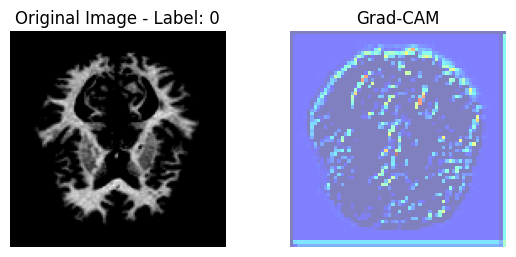

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


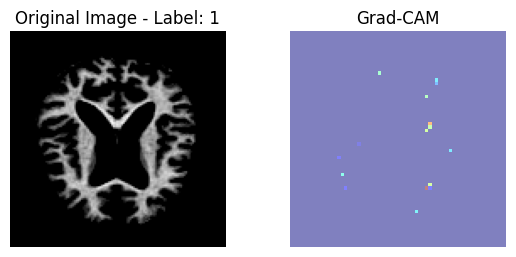

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


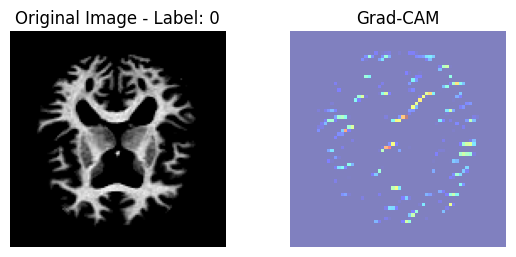

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


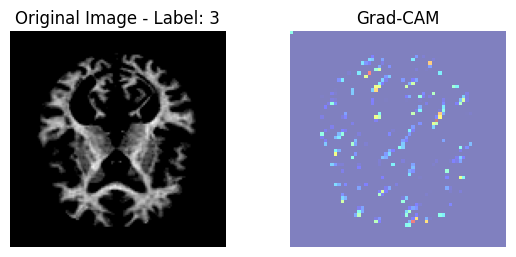

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


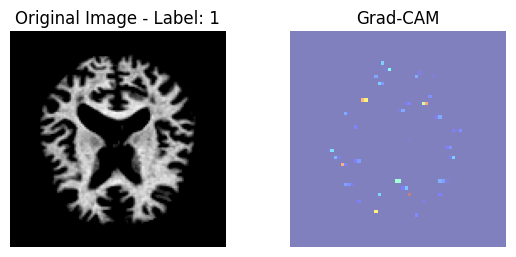

In [42]:
# GradCAM 객체 생성
grad_cam = GradCAM(model=model, target_layer=target_layer)

# 5개의 이미지를 train_loader에서 뽑기
images, labels = get_random_images_from_loader(train_loader, num_images=5)

# 이미지에 대해 Grad-CAM 생성
for i in range(5):
    # Grad-CAM 생성
    cam_image = grad_cam.generate(images[i:i+1], target_class=labels[i].item())  # 이미지와 라벨에 대해 GradCAM 생성

    # 원본 이미지 시각화
    #plt.figure(figsize=(15, 7))  # 이미지 크기를 키움
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))  # 이미지 형태 변환 (채널, 높이, 너비 -> 높이, 너비, 채널)
    plt.title(f"Original Image - Label: {labels[i].item()}")
    plt.axis('off')

    # Grad-CAM 이미지 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image, cmap='jet', alpha=0.5)  # CAM 이미지를 겹쳐서 시각화
    plt.title("Grad-CAM")
    plt.axis('off')

    # 이미지 간 간격 조정
    plt.subplots_adjust(wspace=0.3)  # 이미지 간 간격을 조정 (디폴트 0.2)
    
    plt.show()

# GradCAM hooks 제거
grad_cam.remove_hooks()